In [3]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')
import os

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


In [296]:
B =0 #In mG
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
Δ_hfs = 3*702.4*B
F_3 = 3.845*(10**14)

#Guessing the laser pulse
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 10**10
    return Ω0 * krotov.shapes.blackman(t, t_start=1*10**(-6), t_stop=5.0*10**(-6))


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 10**10
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=4*10**(-6))


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

In [297]:
def hamiltonian(E1,E2,E3):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = -10**9 #E1 + omega_P - E2
    ΔS = -ΔP #E3 + omega_S - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]
H = hamiltonian(0,hfs+Δ_hfs,F_3)

In [298]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

In [299]:
def rwa_target_state(ket3, T=5*10**(-6)):
    return np.exp(1j * (3.845*(10**14) + 10**2) * T) * ket3
psi_target = rwa_target_state(ket3)

In [300]:
#Control objective
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objective

Objective[|Ψ₅₂(3)⟩ to |Ψ₅₃(3)⟩ via [H₁₃₀[3,3], [H₁₃₁[3,3], u₁₀₁(t)], [H₁₃₂[3,3], u₁₀₂(t)], [H₁₃₃[3,3], u₁₀₃(t)], [H₁₃₄[3,3], u₁₀₄(t)]]]

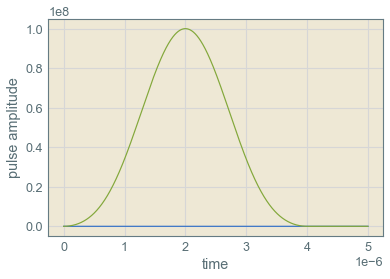

In [301]:
tlist = np.linspace(0, 5*10**(-6), 5000)
def plot_pulse(pulse1,pulse2, tlist, label):
    fig, ax = plt.subplots()
    pulse = tlist
    if callable(pulse1) and callable(pulse2):
        pulse1 = np.array([pulse1(t, args=None) for t in tlist])
        pulse2 = np.array([pulse2(t, args=None) for t in tlist])
    ax.plot(tlist, pulse1,label="pump")
    ax.plot(tlist, pulse2,label="Stokes")
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)
plot_pulse(H[1][1],H[3][1], tlist, '$\Omega$')
#plot_pulse(H[3][1], tlist, 'Ωₛ')

In [302]:
assert np.all([H[2][1](t, None) == 0 for t in tlist])
assert np.all([H[4][1](t, None) == 0 for t in tlist])

In [303]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)
guess_dynamics = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])

In [304]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

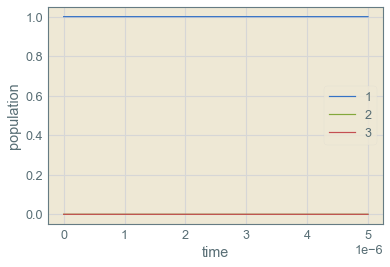

In [305]:
plot_population(guess_dynamics)

# Optimization

In [158]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=5.0*10**(-6), t_rise=0.3*10**(-6), func='sinsq'
    )

In [159]:
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S),
    H[2][1]: dict(lambda_a=0.5, update_shape=S),
    H[3][1]: dict(lambda_a=0.5, update_shape=S),
    H[4][1]: dict(lambda_a=0.5, update_shape=S)
}

In [160]:
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
        unicode=False,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=15,
)

iter.      J_T   g_a_int_1   g_a_int_2   g_a_int_3   g_a_int_4    g_a_int          J  Delta J_T    Delta J  secs
0     1.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00   0.00e+00   1.00e+00        n/a        n/a    19
1     1.00e+00    2.62e-08    2.54e-08    2.24e-08    2.91e-08   1.03e-07   1.00e+00   6.18e-10   1.04e-07    43 **


In [161]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2021-05-19 09:58:24
- Number of objectives: 1
- Number of iterations: 1
- Reason for termination: Reached convergence: Δ(('info_vals', T[-1]),('info_vals', T[-2])) < 1e-05
- Ended at 2021-05-19 09:59:28 (0:01:04)

In [162]:
if not os.path.isfile('lambda_rwa_opt_result.dump'):
    opt_result.dump('lambda_rwa_opt_result.dump')

pump pulse amplitude and phase:


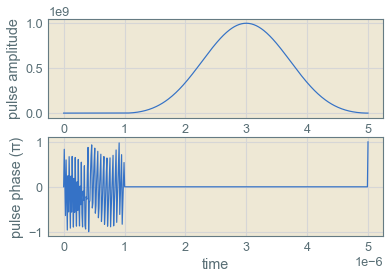

Stokes pulse amplitude and phase:


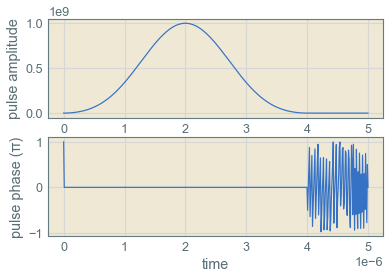

In [163]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()

print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)

Physical electric pump pulse in the lab frame:


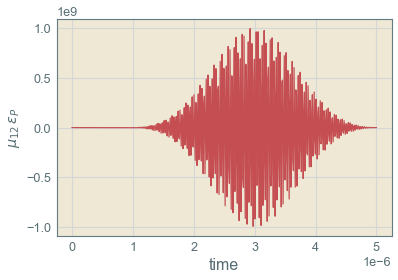

Physical electric Stokes pulse in the lab frame:


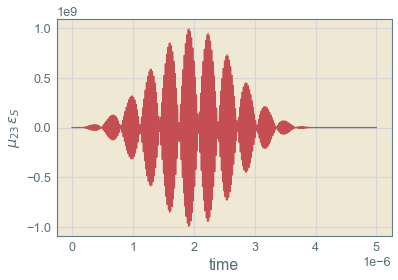

In [164]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w =  5.834673617*(10**9)
    elif case == 'stokes':
        w = -3.845*(10**14) + 10**9
    else:
        print('Error: selected case is not a valid option')
        return

    ax = plt.subplot(111)
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
    elif case == 'stokes':
        ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
    plt.show()

print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')

In [165]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3])

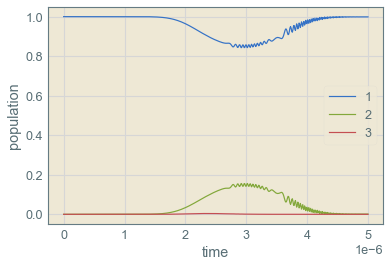

In [166]:
plot_population(opt_dynamics)
